In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopy.distance import great_circle

In [2]:
nb_stores_airtel_money = {
    "Centre": 47,
    "Chari-Baguirmi": 53,
    "Grand Kanem": 48,
    "Grand Logone": 71,
    "Grand Mayo Kebbi": 53,
    "Grand Moyen Chari": 35,
    "Grand Nord": 100,
    "N'Djamena": 252,
}

In [109]:
region_to_district = {
    "N'Djamena": "N'Djamena",
    "Chari-Baguirmi": "Chari-Baguirmi",
    "Hadjer-Lamis": "Chari-Baguirmi",
    "Kanem": "Grand Kanem",
    "Lac": "Grand Kanem",
    "Logone Occidental": "Grand Logone",
    "Logone Oriental": "Grand Logone",
    "Mayo-Kebbi Ouest": "Grand Mayo Kebbi",
    "Mayo-Kebbi Est": "Grand Mayo Kebbi",
    "Moyen-Chari": "Grand Moyen Chari",
    "Salamat": "Grand Moyen Chari",
    "Ouaddaï": "Grand Nord",
    "Wadi Fira": "Grand Nord",
    "Barh-El-Gazel": "Grand Kanem",
    "Batha": "Centre",
    "Borkou": "Grand Nord",
    "Tibesti": "Grand Nord",
    "Ennedi Est": "Grand Nord",
    "Ennedi Ouest": "Grand Nord",
    "Guéra": "Centre",
    "Mandoul": "Grand Moyen Chari",
    "Tandjilé": "Grand Logone",
    "Sila": "Centre",
}

district_to_city = {
    "N'Djamena": "N'Djamena",
    "Chari-Baguirmi": "Massakory",
    "Grand Kanem": "Mao",
    "Grand Logone": "Moundou",
    "Grand Mayo Kebbi": "Pala",
    "Grand Moyen Chari": "Sarh",
    "Grand Nord": "Faya-Largeau",
    "Centre": "Ati",
}

coordinates_district = {
    "N'Djamena": (12.1348, 15.0557),
    "Chari-Baguirmi": (13.0000, 15.7333),
    "Grand Kanem": (14.1194, 15.3139),
    "Grand Logone": (8.5667, 16.0833),
    "Grand Mayo Kebbi": (9.3667, 14.9000),
    "Grand Moyen Chari": (9.1500, 18.3833),
    "Grand Nord": (17.9167, 19.1167),
    "Centre": (13.2154, 18.3353),
}




In [110]:
# Compute distances
neighbors = {}

for city1, coords1 in coordinates_district.items():
    neighbors[city1] = {}
    for city2, coords2 in coordinates_district.items():
        if city1 != city2:
            distance = great_circle(coords1, coords2).kilometers
            neighbors[city1][city2] = distance
            print(f"{city1} : {city2} = {distance:.2f}")

print(neighbors)

N'Djamena : Chari-Baguirmi = 121.09
N'Djamena : Grand Kanem = 222.44
N'Djamena : Grand Logone = 412.37
N'Djamena : Grand Mayo Kebbi = 308.27
N'Djamena : Grand Moyen Chari = 492.30
N'Djamena : Grand Nord = 776.75
N'Djamena : Centre = 375.52
Chari-Baguirmi : N'Djamena = 121.09
Chari-Baguirmi : Grand Kanem = 132.47
Chari-Baguirmi : Grand Logone = 494.44
Chari-Baguirmi : Grand Mayo Kebbi = 414.10
Chari-Baguirmi : Grand Moyen Chari = 516.58
Chari-Baguirmi : Grand Nord = 655.96
Chari-Baguirmi : Centre = 282.81
Grand Kanem : N'Djamena = 222.44
Grand Kanem : Chari-Baguirmi = 132.47
Grand Kanem : Grand Logone = 623.10
Grand Kanem : Grand Mayo Kebbi = 530.39
Grand Kanem : Grand Moyen Chari = 645.76
Grand Kanem : Grand Nord = 586.00
Grand Kanem : Centre = 341.57
Grand Logone : N'Djamena = 412.37
Grand Logone : Chari-Baguirmi = 494.44
Grand Logone : Grand Kanem = 623.10
Grand Logone : Grand Mayo Kebbi = 157.50
Grand Logone : Grand Moyen Chari = 260.89
Grand Logone : Grand Nord = 1090.16
Grand Logo

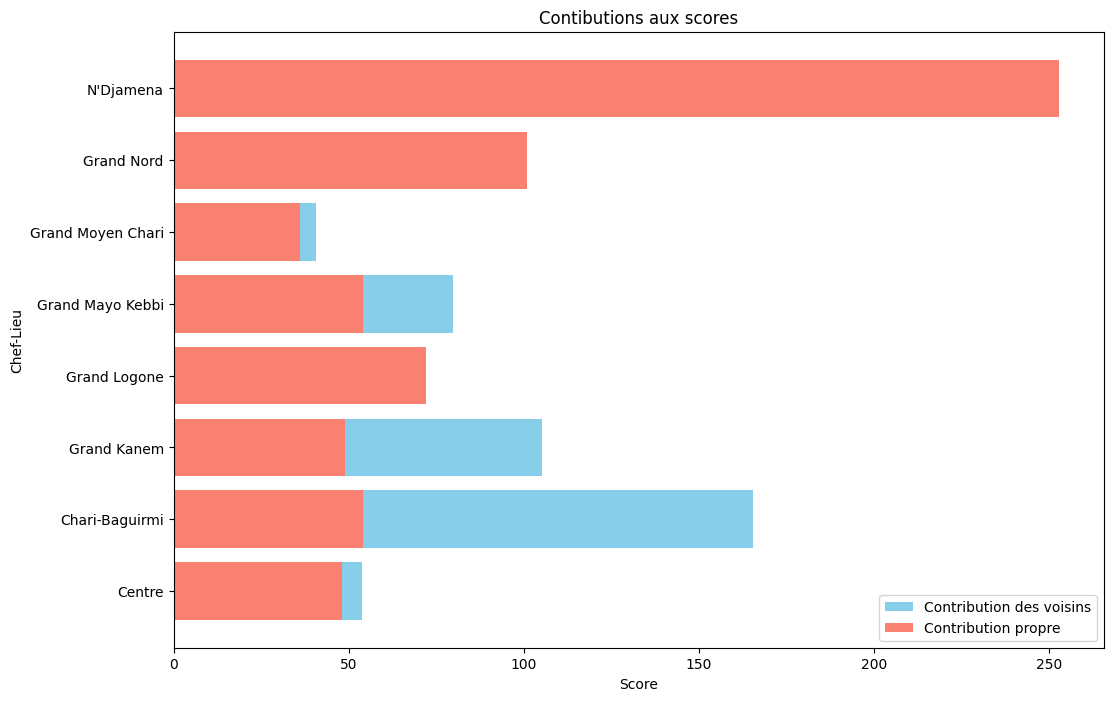

In [111]:

def calculate_isibf1(city_counts, neighbors, alpha, threshold):
    isibf_values = {}
    contributions_voisins={}
    contribution_propre={}
    for city in city_counts:
        total = 0
        for neighbor, distance in neighbors[city].items():
            if distance <= threshold:
                total += (city_counts[neighbor] + 1) / alpha**distance
            else:
                total += 0
        #print(f"{city_to_region[city]}, contribution des voisins = {total:.2f}, contribution propre = {(city_counts[city] + 1):.2f}")
        contributions_voisins[city] = total
        contribution_propre[city] = (city_counts[city] + 1)
        total+= (city_counts[city] + 1)
        isibf_values[city] = total
    #apply mapping to regions for isibf_values
    isibf_values = {region_to_district.get(k, k): v for k, v in isibf_values.items()}
    return contribution_propre, contributions_voisins, isibf_values 

alpha=1.006
threshold = 800
isibf_scores0 = calculate_isibf1(nb_stores_airtel_money, neighbors, alpha, threshold)
#print(isibf_scores0)
# min-max normalization

def min_max_normalize(values):
    min_value = min(values.values())
    max_value = max(values.values())
    normalized_values = {}
    for key, value in values.items():
        normalized_values[key] = (value - min_value) / (max_value - min_value)
        #print(f"{key}: {normalized_values[key]:.2f}")
    return normalized_values

#plot contribution of neighbors and propre contribution for each city

contribution_propre, contributions_voisins, isibf_values = isibf_scores0

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the contributions of neighbors
ax.barh(list(contributions_voisins.keys()), list(contributions_voisins.values()), color='skyblue', label='Contribution des voisins')

# Plot the contributions of the cities themselves
ax.barh(list(contribution_propre.keys()), list(contribution_propre.values()), color='salmon', label='Contribution propre')

#ax.barh(list(isibf_values.keys()), list(isibf_values.values()), color='green', label='ISIBF')


# Add labels and title

ax.set_xlabel('Score')
ax.set_ylabel('Chef-Lieu')
ax.set_title('Contibutions aux scores')
ax.legend()

In [112]:
"""
# Create a dictionary to map scores to regions
region_isibf_values = {}


# Map ISIBF scores to regions
for region, district in region_to_district.items():
    # Get the ISIBF score for the corresponding district
    score = isibf_values.get(district, None)
    
    if score is not None:
        region_isibf_values[region] = score

print(region_isibf_values)
print(len(region_isibf_values))
"""

'\n# Create a dictionary to map scores to regions\nregion_isibf_values = {}\n\n\n# Map ISIBF scores to regions\nfor region, district in region_to_district.items():\n    # Get the ISIBF score for the corresponding district\n    score = isibf_values.get(district, None)\n    \n    if score is not None:\n        region_isibf_values[region] = score\n\nprint(region_isibf_values)\nprint(len(region_isibf_values))\n'

In [113]:
isibf_scores = min_max_normalize(isibf_values)

print(isibf_scores)

#apply .2f to the values of the dictionary and map to regions

isibf_scores = {k: round(v, 2) for k, v in isibf_scores.items()}

# Print the ISIBF scores
print("\nISIBF scores:")
print(isibf_scores)

{'Centre': 0.10616402561731722, 'Chari-Baguirmi': 0.6003374419146632, 'Grand Kanem': 0.32643851022563286, 'Grand Logone': 0.2143297273639855, 'Grand Mayo Kebbi': 0.24072076599792197, 'Grand Moyen Chari': 0.0, 'Grand Nord': 0.13186910399044713, "N'Djamena": 1.0}

ISIBF scores:
{'Centre': 0.11, 'Chari-Baguirmi': 0.6, 'Grand Kanem': 0.33, 'Grand Logone': 0.21, 'Grand Mayo Kebbi': 0.24, 'Grand Moyen Chari': 0.0, 'Grand Nord': 0.13, "N'Djamena": 1.0}


            district                                           geometry  \
0             Centre  POLYGON ((21.81549 12.80436, 21.81557 12.80366...   
1     Chari-Baguirmi  POLYGON ((17.31300 11.31400, 17.31081 11.30442...   
2        Grand Kanem  POLYGON ((15.54366 13.24406, 15.53059 13.21272...   
3       Grand Logone  POLYGON ((17.14396 9.01794, 17.15000 8.97100, ...   
4   Grand Mayo Kebbi  POLYGON ((14.49956 10.00883, 14.49956 10.00883...   
5  Grand Moyen Chari  POLYGON ((17.55400 9.59700, 17.55408 9.59710, ...   
6         Grand Nord  POLYGON ((22.91875 15.48877, 22.91896 15.48820...   
7          N'Djamena  POLYGON ((15.01562 12.21635, 15.04261 12.21657...   

          admin1Name admin1Pcod         admin1RefN         admin1Na_1  \
0              Batha       TD01              Batha              BATHA   
1     Chari-Baguirmi       TD03     Chari-Baguirmi     CHARI-BAGUIRMI   
2              Kanem       TD06              Kanem              KANEM   
3  Logone Occidental       TD08 

<Axes: >

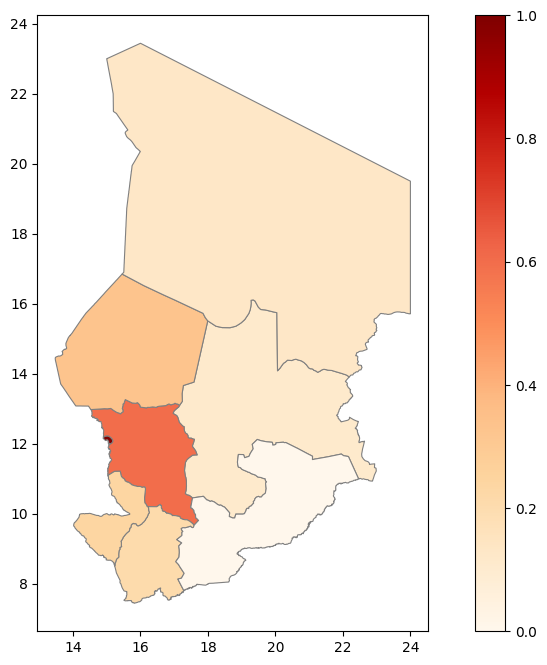

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
tchad = gpd.read_file('/Users/haouabenaliabbo/Desktop/M2 IREN/ALTERNANCE/GitHub/Dashboard-TCHAD/docs/tcd_admbnda_adm1_ocha/tcd_admbnda_adm1_ocha.shp')
tchad['district'] = tchad['admin1Name'].map(region_to_district)


# Dissolve districts and calculate the mean ISIBF score
tchad_merged = tchad.dissolve(by='district')
tchad_merged.reset_index(inplace=True)

# Map ISIBF scores to regions
tchad_merged['ISIBF'] = tchad_merged['district'].map(isibf_scores)

print(tchad_merged)






# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))
tchad_merged.plot(column='ISIBF', cmap='OrRd', linewidth=0.8, edgecolor='grey', ax=ax, legend=True)
# add an edge to the map for districts only

In [114]:
import folium

# Create a map centered on Chad
my_map = folium.Map(location=[15.5, 19.5], zoom_start=5)


# Plot the map using Folium Choropleth
folium.Choropleth(
    geo_data=tchad.__geo_interface__,  # Ensure using the __geo_interface__ for the GeoDataFrame
    name='choropleth',
    data=tchad_merged,
    columns=['district', 'ISIBF'],
    key_on='feature.properties.district',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name='ISIBF score'
).add_to(my_map)

# Add a tooltip to display information
folium.GeoJson(
    tchad_merged.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'OrRd' if feature['properties']['ISIBF'] is not None else 'gray',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.2,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['district', 'ISIBF'],
        aliases=['District:', 'ISIBF Score:'],
        localize=True,
    )
).add_to(my_map)

# Save the map as an HTML file
my_map.save("/Users/haouabenaliabbo/Desktop/M2 IREN/ALTERNANCE/Dashboard/Tchad/isibf_map_mobile_money2.html")

# Optional: Display the map in Jupyter Notebook (if needed)



In [115]:
import geopandas as gpd
import plotly.express as px

# Load the shapefile (ensure this part is done before creating the GeoJSON)


# Convert to GeoJSON
geojson_data = tchad_merged.__geo_interface__

# Create the choropleth map
fig = px.choropleth_mapbox(
    tchad_merged,
    geojson=geojson_data,
    locations='district',  # Column in your GeoDataFrame that contains the district names
    featureidkey='properties.district',  # This should match the GeoJSON structure
    color='ISIBF',  # Column used for color scaling
    mapbox_style="carto-positron",
    zoom=4.9,
    center={"lat": 15.5, "lon": 19.5},
    title="Score d'accès à Airtel Money au Tchad",
    hover_name="district",  # Name shown when hovering over a district
    hover_data={'ISIBF': True, 'district': False},  # Show ISIBF score and hide district name
    labels={'district': 'District', 'ISIBF': 'ISIBF Score'},
    color_continuous_scale=px.colors.sequential.Blues,  # Light to dark blue color scale
)

# Save the map as an HTML file
fig.write_html('/Users/haouabenaliabbo/Desktop/M2 IREN/ALTERNANCE/GitHub/Dashboard-TCHAD/docs/isibf_tchad_mobile_money.html')

# Optional: Display the map in Jupyter Notebook (if needed)


